In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as sps
import random

In [3]:
variables = pd.read_csv('variables_v2.csv')

In [5]:
df_ori = pd.read_csv('clean card transaction.csv')
variables.insert(loc=2, column='date', value=df_ori['Date'])

In [6]:
df_ori.iloc[:,1:]

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0
...,...,...,...,...,...,...,...,...,...,...
96392,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042,P,84.79,0
96393,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248,P,118.75,0
96394,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150,P,363.56,0
96395,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656,P,2202.03,0


In [7]:
features = pd.read_csv('sfs.csv')

In [62]:
def datause(number):
    # choose number of variables
    global data
    data = variables[['Fraud', 'date'] + list(eval(features.loc[number]['feature_names']))]

    # split dataset
    train_test = data[data.date < '2010-11-01']
    oot = data[data.date >= '2010-11-01']
    
    global y_train_test
    y_train_test = train_test['Fraud']
    global y_oot
    y_oot = oot['Fraud']
    global x_train_test
    x_train_test = train_test.iloc[:,2:]
    global x_oot
    x_oot = oot.iloc[:,2:]

    #Z-scale
    x = data.iloc[:,2:]
    scaler = StandardScaler().fit(x)
    x_train_test = scaler.transform(x_train_test)
    x_oot = scaler.transform(x_oot)
    
    return None

In [179]:
# train_test = data[data.date < '2010-11-01']
# oot = data[data.date >= '2010-11-01']

In [180]:
# y_train_test = train_test['Fraud']
# y_oot = oot['Fraud']

In [183]:
# x_train_test = train_test.iloc[:,2:32]
# x_oot = oot.iloc[:,2:32]

In [184]:
# x = data.iloc[:,2:32]
# scaler = StandardScaler().fit(x)
# x_train_test = scaler.transform(x_train_test)
# x_oot = scaler.transform(x_oot)

In [10]:
# fix imbalance issue
#smote = SMOTE(k_neighbors = 3)
#X_smo, y_smo = smote.fit_resample(x_train_test, y_train_test)

In [10]:
def fdr_prob(y, y_prob, cutoff = 0.03):
    if len(y_prob.shape) != 1:
        y_prob = y_prob[:,-1]
    num_fraud = len(y[y == 1])
    
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key = lambda x: x[0], reverse = True))
    
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]
    
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud


def fdr(classifier, x, y, cutoff = 0.03):
    return fdr_prob(y,classifier.predict_proba(x), cutoff)

In [11]:
def FDR(df):
    topRows = int(round(len(df)*0.03))
    bads = df.loc[df['fraud_label'] == 1]
    numbads = len(bads)
    
    temp = df[['fraud_proba','fraud_label']].copy()
    temp0 = temp.sort_values('fraud_proba',ascending=False)
    temp1 = temp0.head(topRows)
    temp2 = temp0.tail(topRows)
    needed1 = temp1.loc[:,'fraud_label']
    needed2 = temp2.loc[:,'fraud_label']
    FDR1 = sum(needed1)/numbads
    FDR2 = sum(needed2)/numbads
    FDRate = np.maximum(FDR1,FDR2) 
    
    return FDRate

**Logistic Model**

In [33]:
log_10times = []


for num,p,s,r,c in zip([75,70,70,65,60,50],
                ['l1', 'l1', 'l2','l2','elasticnet','elasticnet'], 
                   ['saga','liblinear','lbfgs','lbfgs','saga','saga'],
                   [0.5,0,0,0,0.5,0.6],[0.01,10,0.1,0.1,0.01,0.01]):
    datause(num)
    result_log = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(
            x_train_test, y_train_test, test_size = 0.3)

        model = LogisticRegression(penalty = p, solver=s, class_weight = 'balanced', l1_ratio = r, C = c)
        clf = model.fit(X_train, y_train)

        y_train_hat = clf.predict_proba(X_train)
        train = pd.DataFrame()
        train['fraud_label'] = y_train.values
        train['fraud_proba'] = y_train_hat[:,1]
        train_fdr = FDR(train)

        y_test_hat = clf.predict_proba(X_test)
        test = pd.DataFrame()
        test['fraud_label'] = y_test.values
        test['fraud_proba'] = y_test_hat[:,1]
        test_fdr = FDR(test)

        y_oot_hat = clf.predict_proba(x_oot)
        oot = pd.DataFrame()
        oot['fraud_label'] = y_oot.values
        oot['fraud_proba'] = y_oot_hat[:,1]
        oot_fdr = FDR(oot)

        each_run = dict(TRAIN = train_fdr, TEST = test_fdr, OOT = oot_fdr)
        result_log.append(each_run)

    df_log = pd.DataFrame(result_log)

    dict_log = dict(number_of_variables = 80-num, penalty = p, solver = s, regularization_para = c, l1_ratio = r,
                TRAIN_AVG = df_log.TRAIN.mean(), TEST_AVG = df_log.TEST.mean(), OOT_AVG = df_log.OOT.mean())

    log_10times.append(dict_log)

In [34]:
avg_log = pd.DataFrame(log_10times)
avg_log

,number_of_variables,penalty,solver,regularization_para,l1_ratio,TRAIN_AVG,TEST_AVG,OOT_AVG
0,5,l1,saga,0.01,0.5,0.651500,0.658570,0.318994
1,10,l1,liblinear,10.00,0.0,0.664381,0.646589,0.363128
2,10,l2,lbfgs,0.10,0.0,0.657851,0.665897,0.348045
3,15,l2,lbfgs,0.10,0.0,0.665737,0.677120,0.374302
4,20,elasticnet,saga,0.01,0.5,0.677924,0.668539,0.332402
5,30,elasticnet,saga,0.01,0.6,0.689066,0.656862,0.332961


In [35]:
#avg_log.to_csv('result_log.csv')

**Neural Network**

In [30]:
nn_10times = []

for num,h,m,a,s in zip(
    [70,60,65,60,50,50,50],[(5,),(10,),(5,5),(15,),(5,10),(15,),(5,5)], 
    [50,50,100,100,200,200,250], [0.0001,0.001,0.01,0.001,0.01,0.01,0.1],
    ['sgd','adam','adam','sgd','adam','sgd','adam']):
    datause(num)
    result_nn = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(
            x_train_test, y_train_test, test_size = 0.3)    
        model = MLPClassifier(hidden_layer_sizes = h, max_iter = m, alpha = a, solver = s)
        clf = model.fit(X_train, y_train)

        y_train_hat = clf.predict_proba(X_train)
        train = pd.DataFrame()
        train['fraud_label'] = y_train.values
        train['fraud_proba'] = y_train_hat[:,1]
        train_fdr = FDR(train)

        y_test_hat = clf.predict_proba(X_test)
        test = pd.DataFrame()
        test['fraud_label'] = y_test.values
        test['fraud_proba'] = y_test_hat[:,1]
        test_fdr = FDR(test)

        y_oot_hat = clf.predict_proba(x_oot)
        oot = pd.DataFrame()
        oot['fraud_label'] = y_oot.values
        oot['fraud_proba'] = y_oot_hat[:,1]
        oot_fdr = FDR(oot)

        each_run = dict(TRAIN = train_fdr, TEST = test_fdr, OOT = oot_fdr)
        result_nn.append(each_run)
        
    df_nn = pd.DataFrame(result_nn)
    
    dict_nn = dict(number_of_variables = 80-num, hidden_layer = h, epoch = m, alpha = a, solver = s,
                TRAIN_AVG = df_nn.TRAIN.mean(), TEST_AVG = df_nn.TEST.mean(), OOT_AVG = df_nn.OOT.mean())

    nn_10times.append(dict_nn)

In [31]:
avg_nn = pd.DataFrame(nn_10times)
avg_nn

,number_of_variables,hidden_layer,epoch,alpha,solver,TRAIN_AVG,TEST_AVG,OOT_AVG
0,10,"(5,)",50,0.0001,sgd,0.647196,0.651838,0.329609
1,20,"(10,)",50,0.0010,adam,0.758101,0.743809,0.463128
2,15,"(5, 5)",100,0.0100,adam,0.735686,0.713867,0.426257
3,20,"(15,)",100,0.0010,sgd,0.664572,0.643320,0.278771
4,30,"(5, 10)",200,0.0100,adam,0.784898,0.747632,0.491061
5,30,"(15,)",200,0.0100,sgd,0.661814,0.641522,0.289385
6,30,"(5, 5)",250,0.1000,adam,0.754922,0.746569,0.497765


In [36]:
#avg_nn.to_csv('result_nn.csv')

## Random Forest

In [27]:
rf_10times = []

for num,n,m,s,l,k in zip(
    [70,70,70,70,60,65,65,50,70],[50,100,75,150,80,60,100,90,70],
    [10,100,15,50,10,20,15,250,10],[10,15,20,20,25,10,15,20,10],
    [7,9,8,10,8,6,7,10,8],[5,7,6,9,8,6,8,15,8]):
    datause(num)
    result_rf = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(
            x_train_test, y_train_test, test_size = 0.3) 
        
        model = RandomForestClassifier(n_estimators = n, max_depth = m, 
                                       min_samples_split = s, min_samples_leaf = l, 
                                       max_features = k)
        clf = model.fit(X_train, y_train)

        y_train_hat = clf.predict_proba(X_train)
        train = pd.DataFrame()
        train['fraud_label'] = y_train.values
        train['fraud_proba'] = y_train_hat[:,1]
        train_fdr = FDR(train)

        y_test_hat = clf.predict_proba(X_test)
        test = pd.DataFrame()
        test['fraud_label'] = y_test.values
        test['fraud_proba'] = y_test_hat[:,1]
        test_fdr = FDR(test)

        y_oot_hat = clf.predict_proba(x_oot)
        oot = pd.DataFrame()
        oot['fraud_label'] = y_oot.values
        oot['fraud_proba'] = y_oot_hat[:,1]
        oot_fdr = FDR(oot)

        each_run = dict(TRAIN = train_fdr, TEST = test_fdr, OOT = oot_fdr)
        result_rf.append(each_run)
        
    df_rf = pd.DataFrame(result_rf)
    
    dict_rf = dict(number_of_variables = 80 - num, num_of_tree = n, max_depth = m,
                   min_samples_split = s, min_samples_leaf = l, max_features = k,
                TRAIN_AVG = df_rf.TRAIN.mean(), TEST_AVG = df_rf.TEST.mean(), OOT_AVG = df_rf.OOT.mean())

    rf_10times.append(dict_rf)

In [28]:
avg_rf = pd.DataFrame(rf_10times)
avg_rf

,number_of_variables,num_of_tree,max_depth,min_samples_split,min_samples_leaf,max_features,TRAIN_AVG,TEST_AVG,OOT_AVG
0,10,50,10,10,7,5,0.863387,0.797847,0.587151
1,10,100,100,15,9,7,1.000000,0.834386,0.583240
2,10,75,15,20,8,6,0.940926,0.817706,0.594972
3,10,150,50,20,10,9,0.999188,0.854799,0.583240
4,20,80,10,25,8,8,0.860503,0.802613,0.573743
5,15,60,20,10,6,6,0.998858,0.852045,0.570950
6,15,100,15,15,7,8,0.938801,0.843353,0.570391
7,30,90,250,20,10,15,0.999682,0.850935,0.603911
8,10,70,10,10,8,8,0.859887,0.793904,0.591061


In [37]:
#avg_rf.to_csv('result_rf.csv')

**Gradient Boosting**

In [80]:
gb_10times = []


for num,n,m,c,k in zip(
    [60,60,50],[500,800,1000],[5,5,3],[0.01,0.1,0.01],[4,6,5]):
    
    datause(num)
    result_gb = []
    
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(
            x_train_test, y_train_test, test_size = 0.3) 

        model = GradientBoostingClassifier(n_estimators = n, max_depth = m, learning_rate = c, 
                                           max_features = k)
        clf = model.fit(X_train, y_train)

        y_train_hat = clf.predict_proba(X_train)
        train = pd.DataFrame()
        train['fraud_label'] = y_train.values
        train['fraud_proba'] = y_train_hat[:,1]
        train_fdr = FDR(train)

        y_test_hat = clf.predict_proba(X_test)
        test = pd.DataFrame()
        test['fraud_label'] = y_test.values
        test['fraud_proba'] = y_test_hat[:,1]
        test_fdr = FDR(test)

        y_oot_hat = clf.predict_proba(x_oot)
        oot = pd.DataFrame()
        oot['fraud_label'] = y_oot.values
        oot['fraud_proba'] = y_oot_hat[:,1]
        oot_fdr = FDR(oot)

        each_run = dict(TRAIN = train_fdr, TEST = test_fdr, OOT = oot_fdr)
        result_gb.append(each_run)
        
    df_gb = pd.DataFrame(result_gb)
    
    dict_gb = dict(number_of_variables = 80-num, num_of_tree = n, max_depth = m, 
                   learning_rate = c, max_features = k,TRAIN_AVG = df_gb.TRAIN.mean(), 
                   TEST_AVG = df_gb.TEST.mean(), OOT_AVG = df_gb.OOT.mean())

    gb_10times.append(dict_gb)

In [81]:
avg_gb = pd.DataFrame(gb_10times)
avg_gb

,number_of_variables,num_of_tree,max_depth,learning_rate,max_features,TRAIN_AVG,TEST_AVG,OOT_AVG
0,20,500,5,0.01,4,0.914733,0.825875,0.544134
1,20,800,5,0.10,6,0.999675,0.866652,0.555866
2,30,1000,3,0.01,5,0.858549,0.802315,0.551955


In [60]:
#avg_gb.to_csv('result_gb.csv')

**Final Model**

In [38]:
def final_model(X,y):
    model = RandomForestClassifier(n_estimators = 70, max_depth = 10, min_samples_split = 10,
                                   min_samples_leaf = 8, max_features = 8, random_state = 0)

    clf = model.fit(X_train,y_train)
    y_hat = clf.predict_proba(X)
    temp = pd.DataFrame()
    temp['fraud_label'] = y.values
    temp['fraud_proba'] = y_hat[:,1]
    
    N = temp.shape[0]
    temp = temp.sort_values('fraud_proba',ascending=False)
    
    temp_result = []
    
    n = round(N*0.01)
    num_records = 0
    for i in range(20):
        temp1 = temp[num_records:num_records+n]
        num_good = np.unique(temp1['fraud_label'], return_counts = True)[1][0]
        if len(np.unique(temp1['fraud_label'], return_counts = True)[1])==1:
            num_bad = 0
        else:
            num_bad = np.unique(temp1['fraud_label'], return_counts = True)[1][1]
        
        percent_good = num_good/n
        percent_bad = num_bad/n

        dict_temp = dict(num_records = n, num_good = num_good, num_bad = num_bad,\
                        percent_good = percent_good, percent_bad = percent_bad)
        num_records = num_records+n
        temp_result.append(dict_temp)
        
    temp_result = pd.DataFrame(temp_result)   
    return temp_result

In [39]:
datause(70) # 10 variable to use

X_train, X_test, y_train, y_test = train_test_split(
    x_train_test, y_train_test, test_size = 0.3, random_state = 0)

In [40]:
y_train.value_counts()

0    58153
1      626
Name: Fraud, dtype: int64

In [41]:
train_table = final_model(X_train,y_train)

In [42]:
train_table

,num_records,num_good,num_bad,percent_good,percent_bad
0,588,143,445,0.243197,0.756803
1,588,519,69,0.882653,0.117347
2,588,564,24,0.959184,0.040816
3,588,573,15,0.974490,0.025510
4,588,582,6,0.989796,0.010204
5,588,576,12,0.979592,0.020408
6,588,581,7,0.988095,0.011905
7,588,578,10,0.982993,0.017007
8,588,585,3,0.994898,0.005102
9,588,586,2,0.996599,0.003401


In [43]:
#train_table.to_csv('train_table.csv')

In [44]:
test_table = final_model(X_test,y_test)

In [45]:
test_table

,num_records,num_good,num_bad,percent_good,percent_bad
0,252,86,166,0.341270,0.658730
1,252,226,26,0.896825,0.103175
2,252,240,12,0.952381,0.047619
3,252,242,10,0.960317,0.039683
4,252,248,4,0.984127,0.015873
5,252,250,2,0.992063,0.007937
6,252,248,4,0.984127,0.015873
7,252,246,6,0.976190,0.023810
8,252,251,1,0.996032,0.003968
9,252,251,1,0.996032,0.003968


In [46]:
#test_table.to_csv('test_table.csv')

In [47]:
oot_table = final_model(x_oot,y_oot)

In [48]:
oot_table

,num_records,num_good,num_bad,percent_good,percent_bad
0,124,75,49,0.604839,0.395161
1,124,84,40,0.677419,0.322581
2,124,108,16,0.870968,0.129032
3,124,120,4,0.967742,0.032258
4,124,119,5,0.959677,0.040323
5,124,118,6,0.951613,0.048387
6,124,120,4,0.967742,0.032258
7,124,122,2,0.983871,0.016129
8,124,122,2,0.983871,0.016129
9,124,123,1,0.991935,0.008065


In [49]:
#oot_table.to_csv('oot_table.csv')

### Fraud Savings Plot

In [50]:
def fraud_saving_model(X,y):
    model = RandomForestClassifier(n_estimators = 70, max_depth = 10, min_samples_split = 10,
                                      min_samples_leaf = 8, max_features = 8)
    clf = model.fit(X_train,y_train)
    y_hat = clf.predict_proba(X)
    temp = pd.DataFrame()
    temp['fraud_label'] = y.values
    temp['fraud_proba'] = y_hat[:,1]
    
    N = temp.shape[0]
    temp = temp.sort_values('fraud_proba',ascending=False)
    
    temp_result = []
    
    n = round(N*0.01)
    num_records = 0
    for i in range(50):
        temp1 = temp[0:num_records+n]
        num_good = np.unique(temp1['fraud_label'], return_counts = True)[1][0]
        if len(np.unique(temp1['fraud_label'], return_counts = True)[1])==1:
            num_bad = 0
        else:
            num_bad = np.unique(temp1['fraud_label'], return_counts = True)[1][1]
        
        percent_good = num_good/(num_records+n)
        percent_bad = num_bad/(num_records+n)

        dict_temp = dict(num_records = num_records+n, num_good = num_good, num_bad = num_bad,\
                        percent_good = percent_good, percent_bad = percent_bad)
        num_records = num_records + n
        temp_result.append(dict_temp)
        
    temp_result = pd.DataFrame(temp_result)   
    return temp_result

In [51]:
oot_table = fraud_saving_model(x_oot,y_oot)

In [52]:
oot_table['Fraud Savings'] = oot_table['num_bad']*2000
oot_table['Loss Sales'] = oot_table['num_good']*50
oot_table['Overall Savings'] = oot_table['Fraud Savings'] - oot_table['Loss Sales']

In [53]:
oot_table.index = np.arange(1, 51)

In [54]:
oot_table

,num_records,num_good,num_bad,percent_good,percent_bad,Fraud Savings,Loss Sales,Overall Savings
1,124,80,44,0.645161,0.354839,88000,4000,84000
2,248,163,85,0.657258,0.342742,170000,8150,161850
3,372,271,101,0.728495,0.271505,202000,13550,188450
4,496,389,107,0.784274,0.215726,214000,19450,194550
5,620,512,108,0.825806,0.174194,216000,25600,190400
6,744,632,112,0.849462,0.150538,224000,31600,192400
7,868,752,116,0.866359,0.133641,232000,37600,194400
8,992,874,118,0.881048,0.118952,236000,43700,192300
9,1116,994,122,0.890681,0.109319,244000,49700,194300
10,1240,1116,124,0.900000,0.100000,248000,55800,192200


In [55]:
oot_table.sort_values(by = 'Overall Savings', ascending = False)

,num_records,num_good,num_bad,percent_good,percent_bad,Fraud Savings,Loss Sales,Overall Savings
4,496,389,107,0.784274,0.215726,214000,19450,194550
7,868,752,116,0.866359,0.133641,232000,37600,194400
9,1116,994,122,0.890681,0.109319,244000,49700,194300
6,744,632,112,0.849462,0.150538,224000,31600,192400
8,992,874,118,0.881048,0.118952,236000,43700,192300
10,1240,1116,124,0.900000,0.100000,248000,55800,192200
5,620,512,108,0.825806,0.174194,216000,25600,190400
3,372,271,101,0.728495,0.271505,202000,13550,188450
11,1364,1239,125,0.908358,0.091642,250000,61950,188050
12,1488,1361,127,0.914651,0.085349,254000,68050,185950


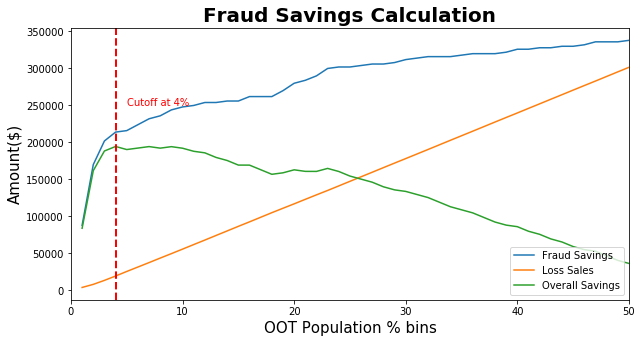

In [58]:
plt.figure(figsize = (10,5))
plt.plot(oot_table['Fraud Savings'], label = 'Fraud Savings')
plt.plot(oot_table['Loss Sales'], label = 'Loss Sales')
plt.plot(oot_table['Overall Savings'], label = 'Overall Savings')
plt.axvline(x=4, color='r', linestyle='dashed', linewidth=2)
plt.text(5, 250000, 'Cutoff at 4%', size=10, color='r')
plt.xlim(0, 50)
plt.title('Fraud Savings Calculation', fontsize  = 20, fontweight = 'bold')
plt.xlabel('OOT Population % bins', fontsize = 15)
plt.ylabel('Amount($)',fontsize = 15)
plt.legend(loc = 'lower right')

### Fraud Score Increase with Activity

In [59]:
df_orin = pd.read_csv('clean card transaction.csv')

In [60]:
df_oot = df_orin.loc[df_orin.Date>= '2010-11-01']

In [64]:
model = RandomForestClassifier(n_estimators = 70, max_depth = 10, min_samples_split = 10,
                                  min_samples_leaf = 8, max_features = 8)
clf = model.fit(x_oot,y_oot)
y_hat = clf.predict_proba(x_oot)


df_oot['fraud_proba'] = y_hat[:,1]

In [65]:
df_oot.sort_values(by = 'fraud_proba', ascending = False).head(30)

,Unnamed: 0,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,fraud_proba
89068,89411,89412,5142235211,2010-11-25,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101,P,3154.26,1,0.983004
89074,89417,89418,5142235211,2010-11-25,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101,P,2967.79,1,0.980806
89057,89400,89401,5142235211,2010-11-25,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101,P,1496.60,1,0.979108
89060,89403,89404,5142235211,2010-11-25,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101,P,935.85,1,0.979108
89055,89398,89399,5142235211,2010-11-25,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101,P,1172.09,1,0.977174
89075,89418,89419,5142235211,2010-11-25,4353000719908,AMAZON.COM *SUPERSTRE,WA,98101,P,483.95,1,0.973535
89077,89420,89421,5142235211,2010-11-25,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101,P,528.02,1,0.971154
89082,89425,89426,5142235211,2010-11-26,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101,P,196.68,1,0.968646
89083,89426,89427,5142235211,2010-11-26,4353000719908,AMAZON.COM *SUPERSTOR,WA,98101,P,382.09,1,0.964938
92902,93251,93252,5142199009,2010-12-14,4353000719908,ACI*AMAZON.COM INC,WA,98101,P,34.85,1,0.957371


In [66]:
df_oot.Date = pd.to_datetime(df_oot.Date, format = '%Y-%m-%d')

In [67]:
df_card = df_oot.loc[df_oot.Cardnum == 5142235211]

Text(0.5, 1.0, 'Cardnum: 5142235211')

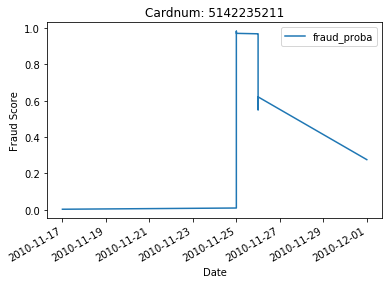

In [69]:
df_card.plot(x='Date',y='fraud_proba',kind='line')
plt.ylabel('Fraud Score')
plt.title('Cardnum: 5142235211')

In [70]:
df_card['count'] = [i for i in range(1,df_card.shape[0]+1)]

Text(0.5, 0, 'Transaction Count with that Cardnum')

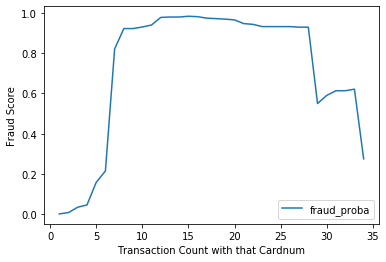

In [71]:
df_card.plot(x='count',y='fraud_proba',kind='line')
plt.ylabel('Fraud Score')
plt.xlabel('Transaction Count with that Cardnum')

In [76]:
df_merch = df_oot.loc[(df_oot.Merchnum == '4353000719908') & (df_oot.Date.between('2010-11-01', '2010-12-01'))]

Text(0.5, 1.0, 'Merchnum: 4353000719908')

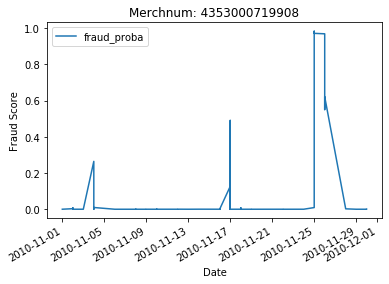

In [77]:
df_merch.plot(x='Date',y='fraud_proba',kind='line')
plt.ylabel('Fraud Score')
plt.title('Merchnum: 4353000719908')

In [78]:
df_merch['count'] = [i for i in range(1,df_merch.shape[0]+1)]

Text(0.5, 0, 'Transaction Count with that Merchnum')

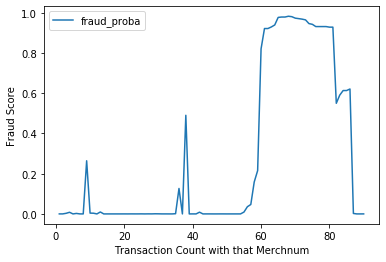

In [79]:
df_merch.plot(x='count',y='fraud_proba',kind='line')
plt.ylabel('Fraud Score')
plt.xlabel('Transaction Count with that Merchnum')